## Credit Risk Benchmark Dataset

Assessing credit risk by predicting whether a borrower will experience serious delinquency within two years. The data comprises a mix of financial metrics and personal attributes, which allow users to build and evaluate models for credit risk scoring.

Table of Content

## 1. Initialization

In [28]:
# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score

# Preprocessing and pipeline utilities
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Utility functions
from collections import Counter

## 2. Data Preprocessing

In [29]:
df=pd.read_csv('/kaggle/input/creditriskbenchmark/Credit Risk Benchmark Dataset (1).csv')
print(df.info())
print()
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16714 entries, 0 to 16713
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   rev_util     16714 non-null  float64
 1   age          16714 non-null  float64
 2   late_30_59   16714 non-null  float64
 3   debt_ratio   16714 non-null  float64
 4   monthly_inc  16714 non-null  float64
 5   open_credit  16714 non-null  float64
 6   late_90      16714 non-null  float64
 7   real_estate  16714 non-null  float64
 8   late_60_89   16714 non-null  float64
 9   dependents   16714 non-null  float64
 10  dlq_2yrs     16714 non-null  int64  
dtypes: float64(10), int64(1)
memory usage: 1.4 MB
None

   rev_util   age  late_30_59  debt_ratio  monthly_inc  open_credit  late_90  \
0  0.006999  38.0         0.0    0.302150       5440.0          4.0      0.0   
1  0.704592  63.0         0.0    0.471441       8000.0          9.0      0.0   
2  0.063113  57.0         0.0    0.068586       

Null Data

In [30]:
print('Null Data:\n',df.isna().sum())

Null Data:
 rev_util       0
age            0
late_30_59     0
debt_ratio     0
monthly_inc    0
open_credit    0
late_90        0
real_estate    0
late_60_89     0
dependents     0
dlq_2yrs       0
dtype: int64


Duplicated Data

In [31]:
print('Duplicated Data',df.duplicated().sum())
#duplicados = df[df.duplicated()]
#print(duplicados)
print('Duplicate Data',df.drop_duplicates(inplace=True))

Duplicated Data 2
Duplicate Data None


Remarks: The Data set is complete by the data source and the Duplicated data was removed

Adding New Variables

In [32]:
# Relación ingreso-deuda
df['income_to_debt'] = df['monthly_inc'] / (df['debt_ratio'] + 1e-5)  # evitamos división por cero

# Total de morosidades (past)
df['total_late'] = df['late_30_59'] + df['late_60_89'] + df['late_90']

# Edad por crédito activo (¿tiene experiencia crediticia?)
df['age_per_credit'] = df['age'] / (df['open_credit'] + 1)

# Ratio real estate vs total créditos (¿cuántos créditos son hipotecarios?)
df['real_estate_ratio'] = df['real_estate'] / (df['open_credit'] + 1)


#### **Income to Debt**

* **`income_to_debt`**: Estimates how much monthly income the user has per unit of their debt ratio.
* Helps assess the user's **relative repayment capacity**.

#### **Total Late**

* **`total_late`**: Sums all instances in which the user has been delinquent across different time ranges.
* Provides a **consolidated metric of past payment delinquency history**.

#### **Age per Credit**

* **`age_per_credit`**: Represents the average user age per active credit line.
* May indicate **financial maturity** or **potential overexposure to credit** depending on age.

#### **Real Estate Ratio**

* **`real_estate_ratio`**: Indicates the proportion of credit lines that are related to real estate.
* Useful for analyzing **risks associated with mortgage debt** versus other types of credit.

In [33]:
print(df.info())
print()
print(df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 16712 entries, 0 to 16713
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rev_util           16712 non-null  float64
 1   age                16712 non-null  float64
 2   late_30_59         16712 non-null  float64
 3   debt_ratio         16712 non-null  float64
 4   monthly_inc        16712 non-null  float64
 5   open_credit        16712 non-null  float64
 6   late_90            16712 non-null  float64
 7   real_estate        16712 non-null  float64
 8   late_60_89         16712 non-null  float64
 9   dependents         16712 non-null  float64
 10  dlq_2yrs           16712 non-null  int64  
 11  income_to_debt     16712 non-null  float64
 12  total_late         16712 non-null  float64
 13  age_per_credit     16712 non-null  float64
 14  real_estate_ratio  16712 non-null  float64
dtypes: float64(14), int64(1)
memory usage: 2.0 MB
None

   rev_util   age  late

## 3 Exploratory Data Analysis

In [34]:
print('General Descriptions')
print(df.describe())

General Descriptions
           rev_util           age    late_30_59    debt_ratio    monthly_inc  \
count  16712.000000  16712.000000  16712.000000  16712.000000   16712.000000   
mean       4.800316     48.799904      1.104536     30.984006    6118.792604   
std      204.074552     13.905283      7.134048    719.737845    5931.875772   
min        0.000000     21.000000      0.000000      0.000000       0.000000   
25%        0.082360     38.000000      0.000000      0.156079    3130.000000   
50%        0.442986     48.000000      0.000000      0.322318    5000.000000   
75%        0.926588     58.000000      1.000000      0.533458    7574.250000   
max    22000.000000    101.000000     98.000000  61106.500000  250000.000000   

        open_credit       late_90   real_estate    late_60_89    dependents  \
count  16712.000000  16712.000000  16712.000000  16712.000000  16712.000000   
mean       8.504727      0.858006      1.047571      0.728578      0.944471   
std        5.370480  

3.1 Pair Plot Graph

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

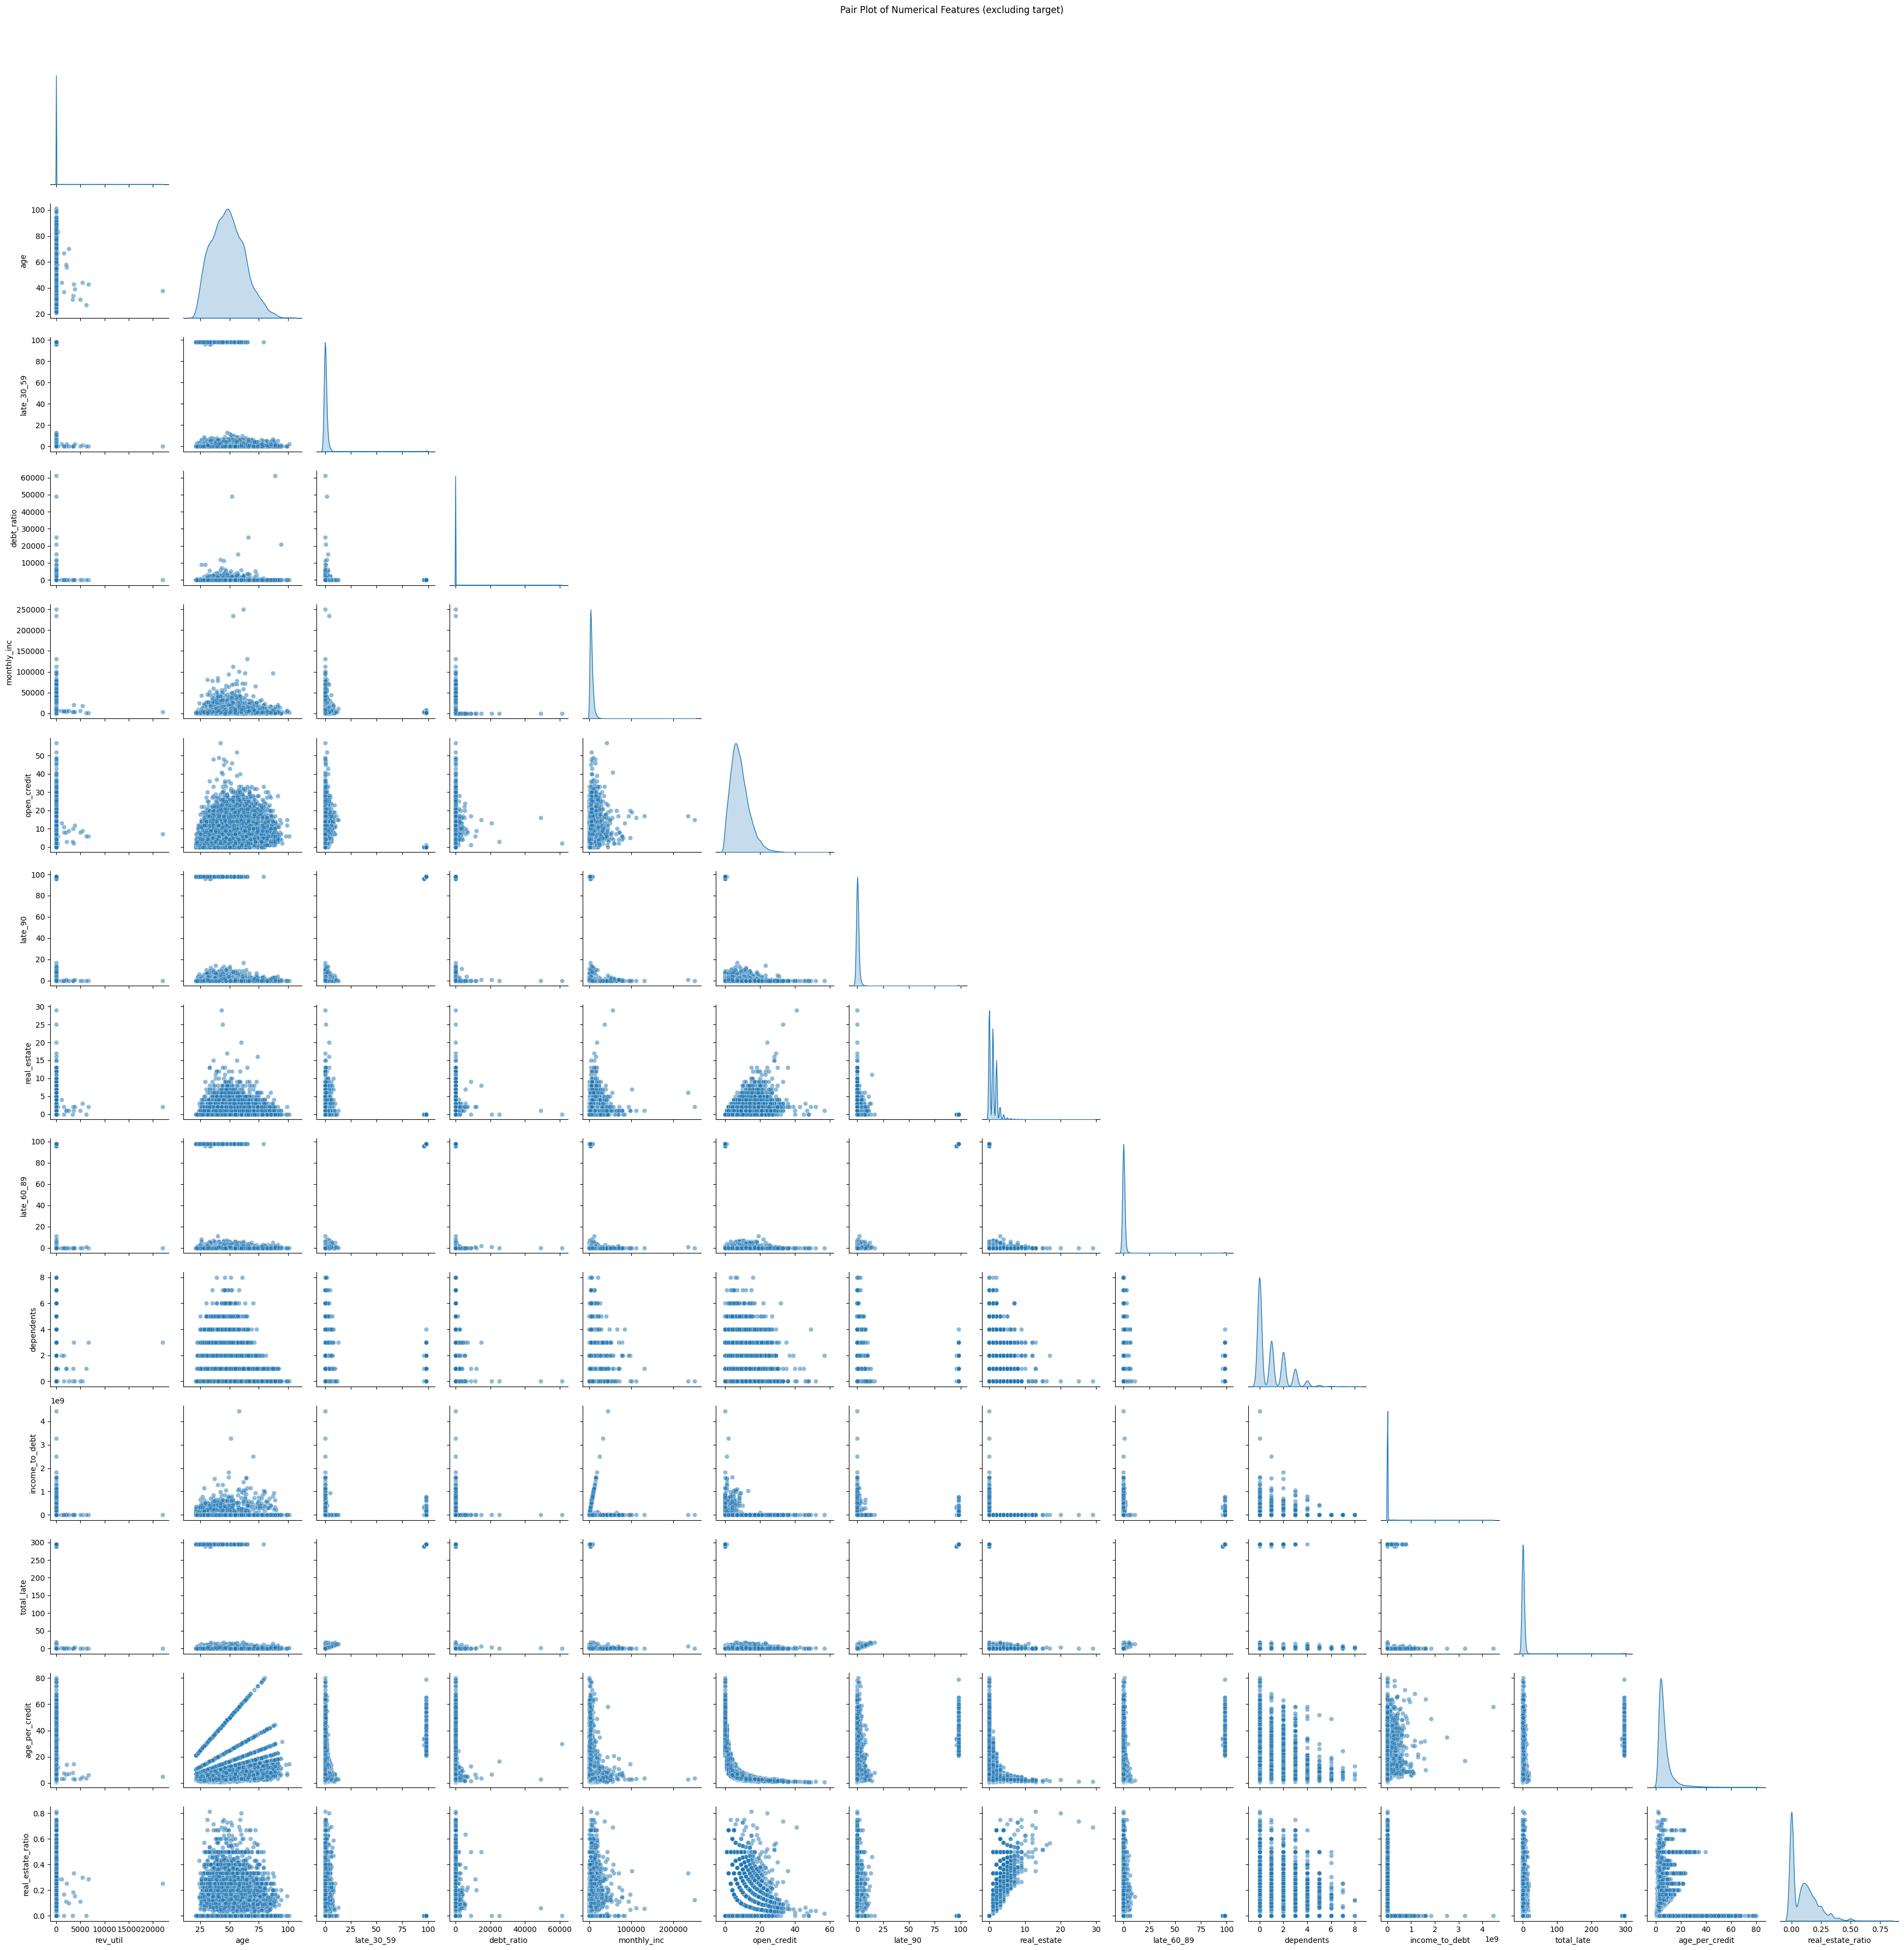

In [35]:
cols_numericas = df.select_dtypes(include='number').columns.drop('dlq_2yrs')

sns.pairplot(
    df,
    diag_kind='kde',
    corner=True,
    plot_kws={'alpha': 0.5},
    vars=cols_numericas
)

plt.suptitle('Pair Plot of Numerical Features (excluding target)', y=1.02)
plt.tight_layout()
plt.show()

🔍 General Interpretation of the Pair Plot
Diagonal Distributions:
- The diagonal shows the distribution of each numerical feature.
- Many variables (e.g., monthly_inc, open_credit, rev_util, debt_ratio) are right-skewed, meaning most values are concentrated on the lower end with a few high outliers.

Scatter Plots (Lower Triangle):
- Most variable pairs show no strong linear relationships — the scatter points appear randomly dispersed.
- There is a mild positive trend between some variables:

📈 monthly_inc vs open_credit: As income increases, people tend to have more open credit lines — a potentially logical financial relationship.
- Some variables, such as late_30_59, late_60_89, late_90, and dependents, appear as discrete steps rather than continuous clouds — likely due to them being count-type variables.

Data Density and Overlap:
- Certain scatter plots have dense overlapping areas at low values, suggesting that many individuals share similar low-income or low-debt profiles.

3.2 Correlation Matrix

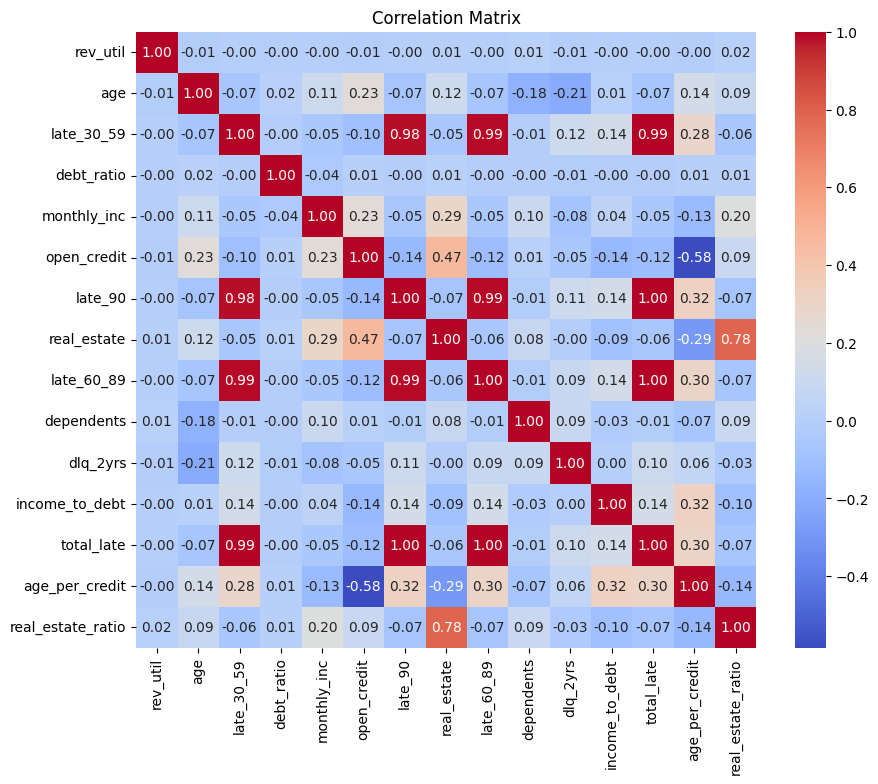

In [36]:
corr = df.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

Target Variable: dlq_2yrs
* Weak correlations with all features:
- The highest absolute correlation is with age: -0.21

📉 Suggests that younger individuals are slightly more likely to have recent delinquencies.
- Other correlations (e.g., with late_30_59, monthly_inc, etc.) are all below ±0.12, indicating very weak linear relationships.

Feature-to-Feature Correlations

✅ Strong multicollinearity:
- late_30_59, late_60_89, and late_90 are all strongly correlated with each other (~0.98–0.99):
- They may represent overlapping aspects of payment delinquency windows.

🔁 Action: Consider combining them or applying dimensionality reduction (e.g., PCA), or choose one to avoid redundancy.

✅ Moderate correlation:
- real_estate shows a moderate positive correlation with open_credit (0.47) and monthly_inc (0.29).
- This makes intuitive sense: owning real estate may be linked to higher income and more credit lines.

Histogram Graphs

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


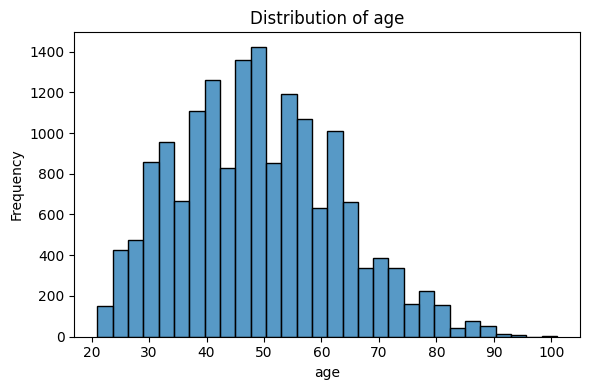

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


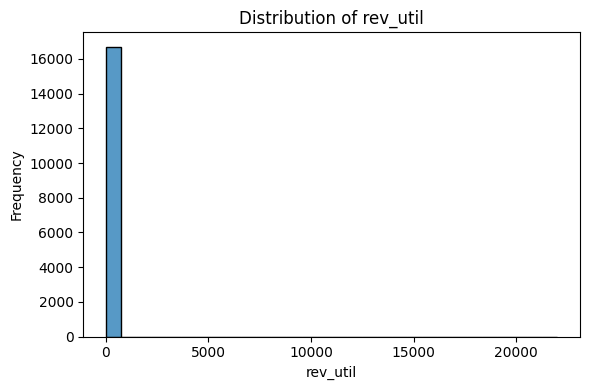

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


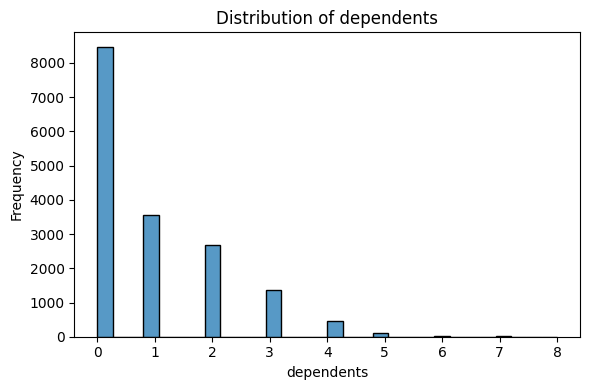

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


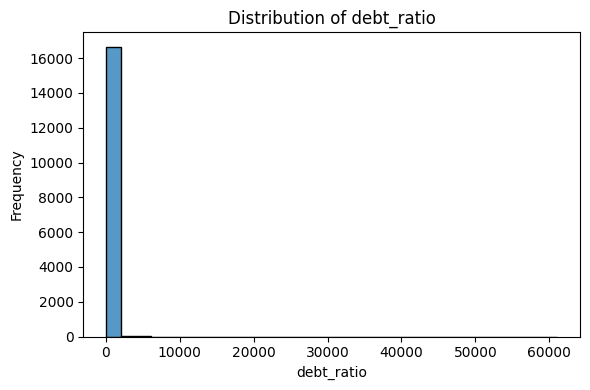

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


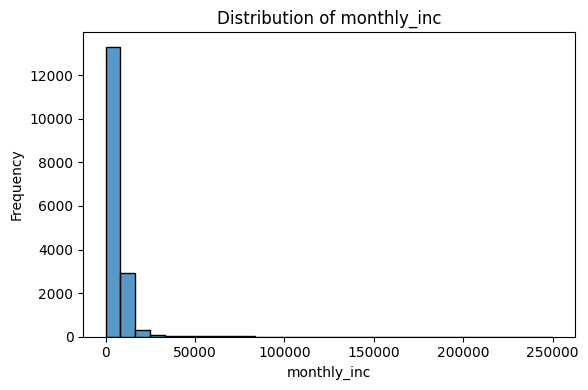

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


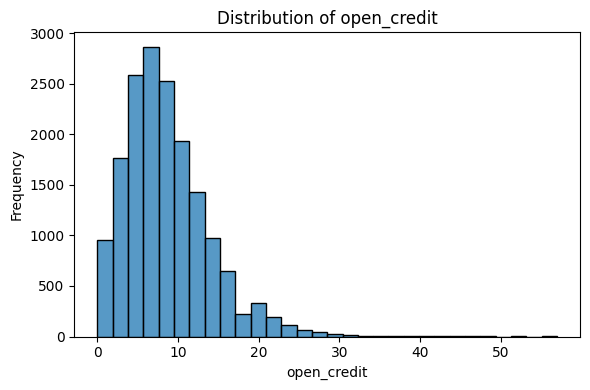

In [37]:
features = ['age', 'rev_util','dependents','debt_ratio', 'monthly_inc', 'open_credit']

for feature in features:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[feature].dropna(), bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

4. Group by incomes

      age  monthly_inc
0    21.0  1243.625000
1    22.0  1506.622222
2    23.0  1789.909091
3    24.0  1987.663551
4    25.0  2530.007092
..    ...          ...
73   94.0   633.333333
74   95.0  3738.000000
75   98.0  2152.000000
76   99.0  6436.000000
77  101.0  2883.000000

[78 rows x 2 columns]


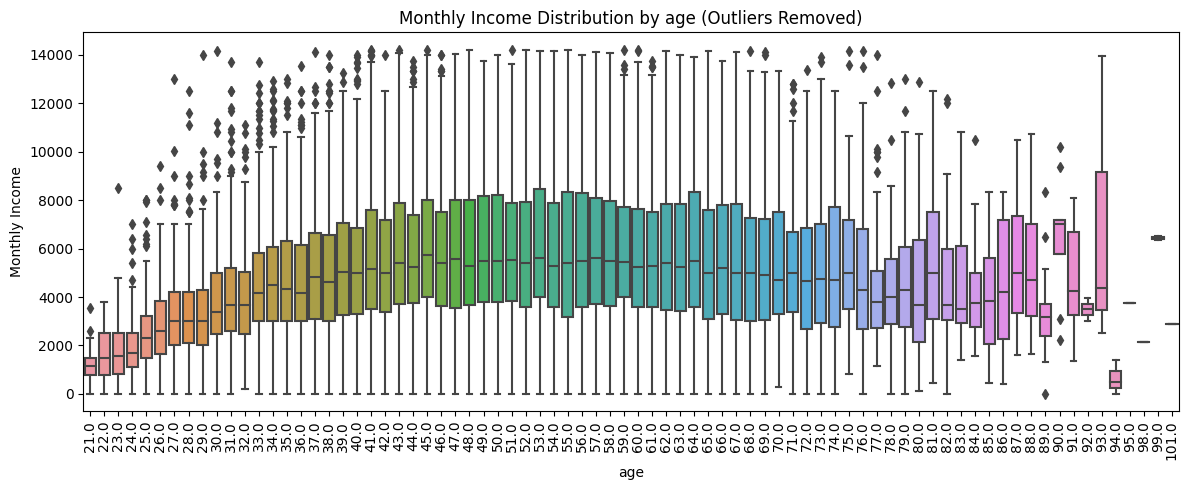

   dependents  monthly_inc
0         0.0  4884.123504
1         1.0  5649.070557
2         2.0  5764.339929
3         3.0  5824.525213
4         4.0  6183.021277
5         5.0  6686.754717
6         6.0  6722.600000
7         7.0  7441.500000
8         8.0  4956.000000


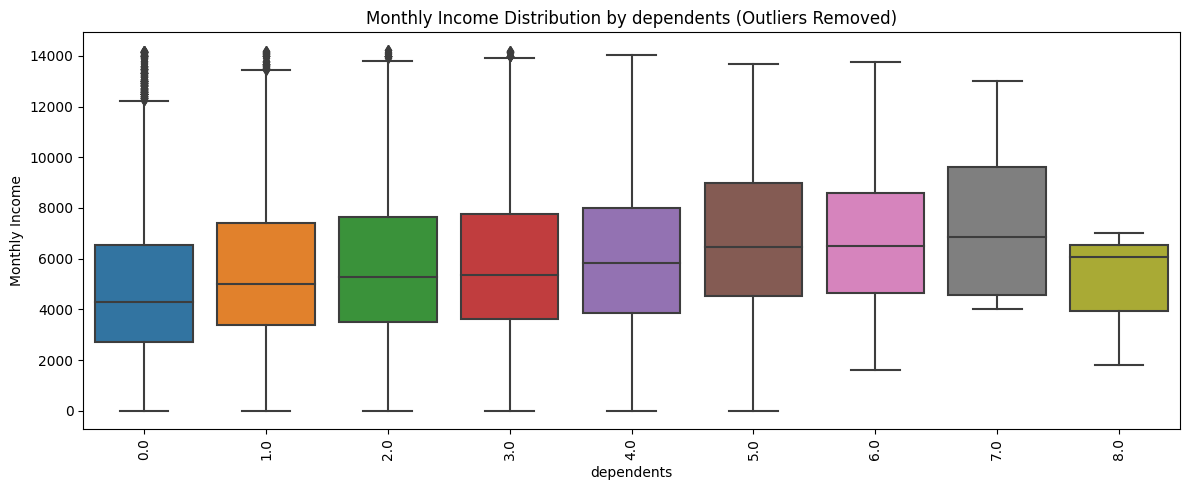

    open_credit   monthly_inc
0           0.0   3059.113573
1           1.0   3379.125862
2           2.0   3595.684211
3           3.0   4160.195804
4           4.0   4494.193860
5           5.0   4866.330154
6           6.0   5045.587518
7           7.0   5319.911143
8           8.0   5430.730989
9           9.0   5737.563803
10         10.0   5865.063830
11         11.0   5996.687799
12         12.0   6070.543046
13         13.0   6138.340206
14         14.0   6530.525667
15         15.0   6702.122010
16         16.0   6546.618462
17         17.0   6647.905303
18         18.0   6939.542714
19         19.0   6874.985294
20         20.0   6972.860759
21         21.0   6975.224490
22         22.0   7312.175676
23         23.0   6902.396552
24         24.0   6957.523810
25         25.0   6583.586207
26         26.0   7072.458333
27         27.0   7161.526316
28         28.0   6745.066667
29         29.0   5627.833333
30         30.0   7523.888889
31         31.0   8443.500000
32        

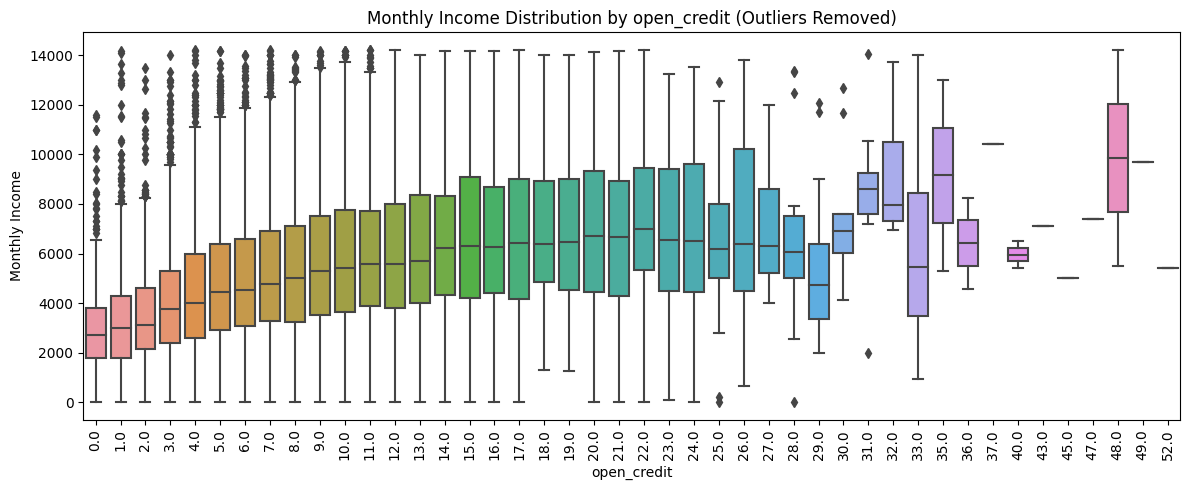

In [38]:
features = ['age', 'dependents', 'open_credit']

for feature in features:
    Q1 = df['monthly_inc'].quantile(0.25)
    Q3 = df['monthly_inc'].quantile(0.75)
    IQR = Q3 - Q1

    df_filtered = df[(df['monthly_inc'] >= Q1 - 1.5 * IQR) & (df['monthly_inc'] <= Q3 + 1.5 * IQR)]

    df_grouped_income = df_filtered.groupby(feature, as_index=False)['monthly_inc'].mean()
    print(df_grouped_income)

    plt.figure(figsize=(12, 5))
    sns.boxplot(x=feature, y='monthly_inc', data=df_filtered)
    plt.xticks(rotation=90)
    plt.title(f'Monthly Income Distribution by {feature} (Outliers Removed)')
    plt.xlabel(feature)
    plt.ylabel('Monthly Income')
    plt.tight_layout()
    plt.show()


      age  monthly_inc
0    21.0  1243.625000
1    22.0  1506.622222
2    23.0  1789.909091
3    24.0  1987.663551
4    25.0  2530.007092
..    ...          ...
73   94.0   633.333333
74   95.0  3738.000000
75   98.0  2152.000000
76   99.0  6436.000000
77  101.0  2883.000000

[78 rows x 2 columns]


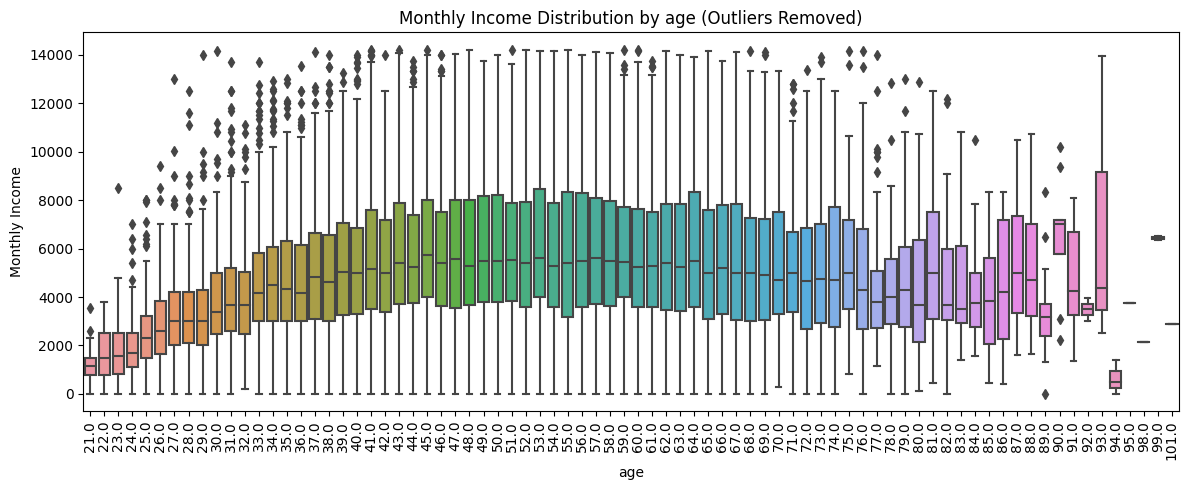

   dependents  monthly_inc
0         0.0  4884.123504
1         1.0  5649.070557
2         2.0  5764.339929
3         3.0  5824.525213
4         4.0  6183.021277
5         5.0  6686.754717
6         6.0  6722.600000
7         7.0  7441.500000
8         8.0  4956.000000


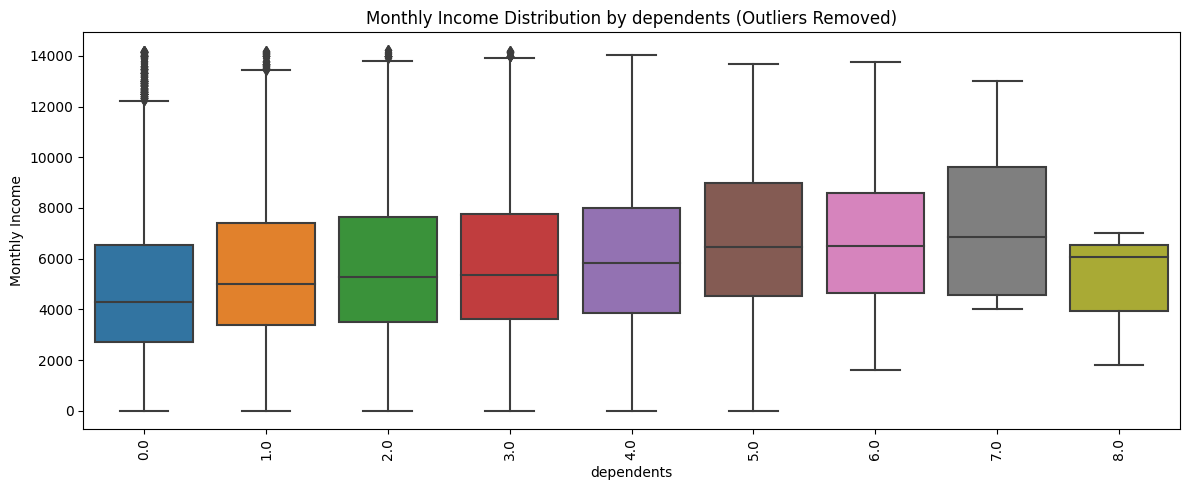

    open_credit   monthly_inc
0           0.0   3059.113573
1           1.0   3379.125862
2           2.0   3595.684211
3           3.0   4160.195804
4           4.0   4494.193860
5           5.0   4866.330154
6           6.0   5045.587518
7           7.0   5319.911143
8           8.0   5430.730989
9           9.0   5737.563803
10         10.0   5865.063830
11         11.0   5996.687799
12         12.0   6070.543046
13         13.0   6138.340206
14         14.0   6530.525667
15         15.0   6702.122010
16         16.0   6546.618462
17         17.0   6647.905303
18         18.0   6939.542714
19         19.0   6874.985294
20         20.0   6972.860759
21         21.0   6975.224490
22         22.0   7312.175676
23         23.0   6902.396552
24         24.0   6957.523810
25         25.0   6583.586207
26         26.0   7072.458333
27         27.0   7161.526316
28         28.0   6745.066667
29         29.0   5627.833333
30         30.0   7523.888889
31         31.0   8443.500000
32        

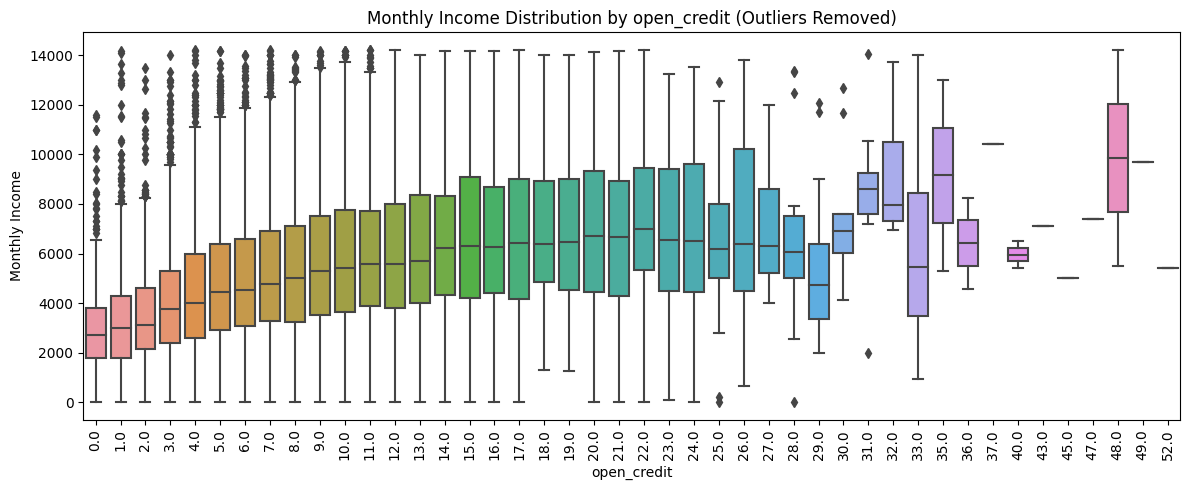

In [39]:
features = ['age', 'dependents', 'open_credit']

for feature in features:
    Q1 = df['monthly_inc'].quantile(0.25)
    Q3 = df['monthly_inc'].quantile(0.75)
    IQR = Q3 - Q1

    df_filtered = df[(df['monthly_inc'] >= Q1 - 1.5 * IQR) & (df['monthly_inc'] <= Q3 + 1.5 * IQR)]

    df_grouped_income = df_filtered.groupby(feature, as_index=False)['monthly_inc'].mean()
    print(df_grouped_income)

    plt.figure(figsize=(12, 5))
    sns.boxplot(x=feature, y='monthly_inc', data=df_filtered)
    plt.xticks(rotation=90)
    plt.title(f'Monthly Income Distribution by {feature} (Outliers Removed)')
    plt.xlabel(feature)
    plt.ylabel('Monthly Income')
    plt.tight_layout()
    plt.show()

Open Credits and Real Estage vs Age

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


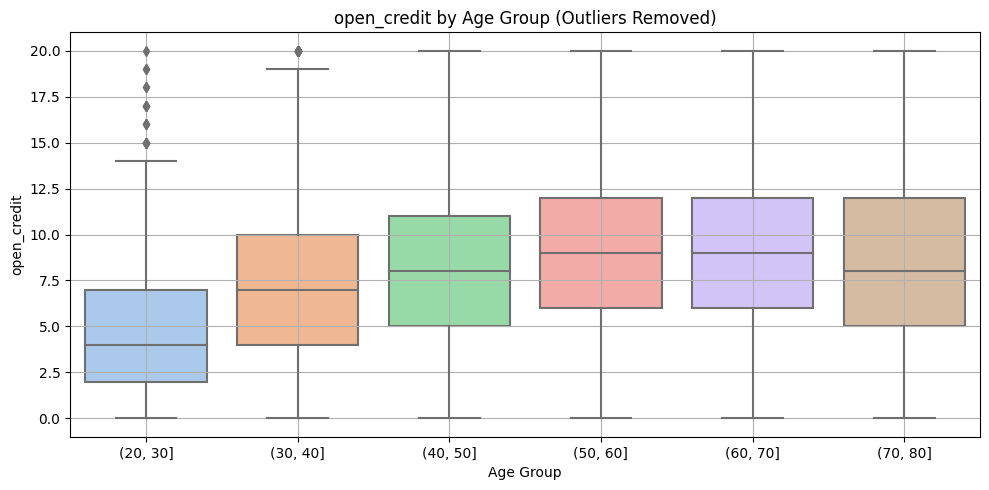

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


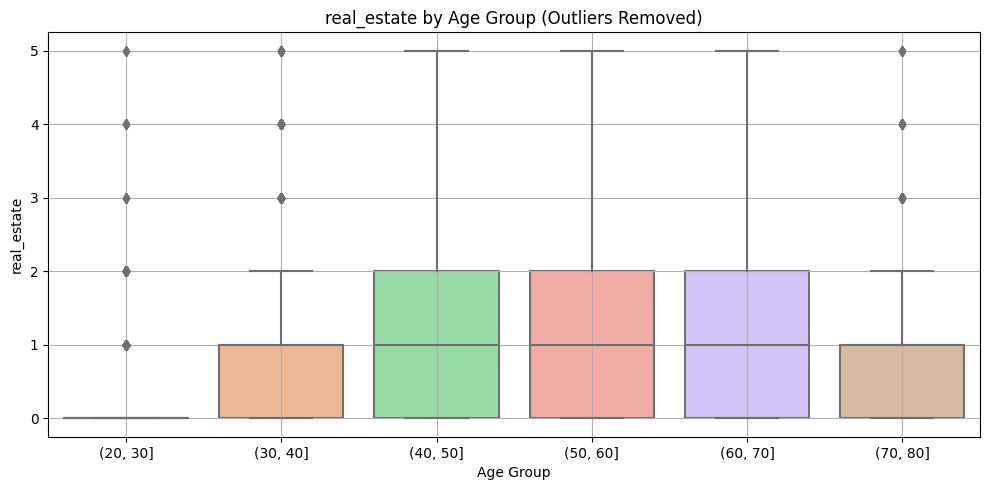

In [40]:
df_plot = df.copy()

# Crear rangos de edad
df_plot['age_group'] = pd.cut(df_plot['age'], bins=[20, 30, 40, 50, 60, 70, 80])

# Hacer boxplots por age_group para cada variable
for feature in ['open_credit', 'real_estate']:
    # Eliminar outliers IQR para la variable actual
    Q1 = df_plot[feature].quantile(0.25)
    Q3 = df_plot[feature].quantile(0.75)
    IQR = Q3 - Q1

    df_filtered = df_plot[
        (df_plot[feature] >= Q1 - 1.5 * IQR) & (df_plot[feature] <= Q3 + 1.5 * IQR)
    ]

    plt.figure(figsize=(10, 5))
    sns.boxplot(data=df_filtered, x='age_group', y=feature, palette='pastel')
    plt.title(f'{feature} by Age Group (Outliers Removed)')
    plt.xlabel('Age Group')
    plt.ylabel(feature)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## 📊 Visual Insights – Data Exploration Conclusions

### 1. Age and Credit Activity

* **The number of open credit lines increases with age**, especially between ages **40 and 65**, indicating greater credit access and financial activity during prime earning years.

### 2. Age and Real Estate Loans

* **Older individuals hold more real estate loans**, with the **peak around age 55–65**. This may reflect greater financial stability or mortgage activity in middle to late career stages.

### 3. Age and Income

* **Monthly income also increases with age**, reaching its **maximum between ages 45 and 60**. After that, income levels off or drops slightly—likely reflecting retirement or reduced work activity.

### 4. Debt Ratio and Age

* Debt ratio appears **more volatile in younger individuals**, stabilizing with age. This suggests younger people may be more financially vulnerable or over-leveraged.

### 5. Late Payments and Age

* **Late payment frequency decreases as age increases**, implying that **older borrowers tend to be more financially responsible or consistent with repayment**.

### 6. Outliers and Distributions

* Variables like `monthly_income` and `debt_ratio` showed **skewed distributions with long tails**, which were handled using **IQR filtering** to remove extreme outliers and improve model stability.

## 4. Models

In [41]:
print(df.head())

   rev_util   age  late_30_59  debt_ratio  monthly_inc  open_credit  late_90  \
0  0.006999  38.0         0.0    0.302150       5440.0          4.0      0.0   
1  0.704592  63.0         0.0    0.471441       8000.0          9.0      0.0   
2  0.063113  57.0         0.0    0.068586       5000.0         17.0      0.0   
3  0.368397  68.0         0.0    0.296273       6250.0         16.0      0.0   
4  1.000000  34.0         1.0    0.000000       3500.0          0.0      0.0   

   real_estate  late_60_89  dependents  dlq_2yrs  income_to_debt  total_late  \
0          1.0         0.0         3.0         0    1.800369e+04         0.0   
1          1.0         0.0         0.0         0    1.696889e+04         0.0   
2          0.0         0.0         0.0         0    7.289025e+04         0.0   
3          2.0         0.0         0.0         0    2.109473e+04         0.0   
4          0.0         0.0         1.0         0    3.500000e+08         1.0   

   age_per_credit  real_estate_ratio  

In [42]:
results_list = []

Features and Target Split for Training, Valuation And Test

In [43]:
features = df.drop(columns='dlq_2yrs')
target = df['dlq_2yrs']

features_temp, features_test, target_temp, target_test = train_test_split(
    features, target, test_size=0.20, stratify=target, random_state=42
)

features_train, features_val, target_train, target_val = train_test_split(
    features_temp, target_temp, test_size=0.20, stratify=target_temp, random_state=42
)

print(f"Train: {features_train.shape}, Val: {features_val.shape}, Test: {features_test.shape}")

Train: (10695, 14), Val: (2674, 14), Test: (3343, 14)


4.1 Logistic Regression

In [44]:
# 1. Crear pipeline
logreg_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])

# 2. Entrenar el modelo
logreg_pipeline.fit(features_train, target_train)

# 3. Evaluar en el conjunto de validación
val_preds = logreg_pipeline.predict(features_val)
val_proba = logreg_pipeline.predict_proba(features_val)[:, 1]

test_preds = logreg_pipeline.predict(features_test)
test_proba = logreg_pipeline.predict_proba(features_test)[:, 1]

# 4. Resultados
print("📊 Classification Report (Validation):")
print(classification_report(target_val, val_preds))

print("\n🔍 Confusion Matrix (Validation):")
print(confusion_matrix(target_val, val_preds))

print("📊 Classification Report (Test):")
print(classification_report(target_test, test_preds))

print("\n🔍 Confusion Matrix (Test):")
print(confusion_matrix(target_test, test_preds))

print("\n🎯 ROC-AUC Score (Validation):", roc_auc_score(target_val, val_proba))


📊 Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.69      0.81      0.75      1337
           1       0.77      0.64      0.70      1337

    accuracy                           0.73      2674
   macro avg       0.73      0.73      0.72      2674
weighted avg       0.73      0.73      0.72      2674


🔍 Confusion Matrix (Validation):
[[1077  260]
 [ 475  862]]
📊 Classification Report (Test):
              precision    recall  f1-score   support

           0       0.69      0.80      0.74      1672
           1       0.76      0.63      0.69      1671

    accuracy                           0.72      3343
   macro avg       0.72      0.72      0.71      3343
weighted avg       0.72      0.72      0.71      3343


🔍 Confusion Matrix (Test):
[[1340  332]
 [ 616 1055]]

🎯 ROC-AUC Score (Validation): 0.7943044436326653


In [45]:
results = {
    'Model': 'Logistic Regression',
    'Validation ROC-AUC': roc_auc_score(target_val, val_proba),
    'Test ROC-AUC': roc_auc_score(target_test, test_proba),
    'Validation F1': f1_score(target_val, val_preds),
    'Test F1': f1_score(target_test, test_preds),
}
results_list.append(results)

4.2 Random Forest

In [46]:
# 2. Pipeline con imputación + escalado + Random Forest
rf_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        class_weight='balanced',
        random_state=12345
    ))
])

# 3. Entrenamiento
rf_pipeline.fit(features_train, target_train)

# 4. Predicciones
val_preds = rf_pipeline.predict(features_val)
val_proba = rf_pipeline.predict_proba(features_val)[:, 1]

test_preds = rf_pipeline.predict(features_test)
test_proba = rf_pipeline.predict_proba(features_test)[:, 1]

# 5. Evaluación
print("📊 Classification Report (Validation):")
print(classification_report(target_val, val_preds))

print("\n🔍 Confusion Matrix (Validation):")
print(confusion_matrix(target_val, val_preds))

print("\n🎯 ROC-AUC Score (Validation):", roc_auc_score(target_val, val_proba))

print("\n📊 Classification Report (Test):")
print(classification_report(target_test, test_preds))

print("\n🔍 Confusion Matrix (Test):")
print(confusion_matrix(target_test, test_preds))

print("\n🎯 ROC-AUC Score (Test):", roc_auc_score(target_test, test_proba))

📊 Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.76      0.77      0.76      1337
           1       0.77      0.75      0.76      1337

    accuracy                           0.76      2674
   macro avg       0.76      0.76      0.76      2674
weighted avg       0.76      0.76      0.76      2674


🔍 Confusion Matrix (Validation):
[[1031  306]
 [ 334 1003]]

🎯 ROC-AUC Score (Validation): 0.8360340216237806

📊 Classification Report (Test):
              precision    recall  f1-score   support

           0       0.77      0.78      0.77      1672
           1       0.78      0.77      0.77      1671

    accuracy                           0.77      3343
   macro avg       0.77      0.77      0.77      3343
weighted avg       0.77      0.77      0.77      3343


🔍 Confusion Matrix (Test):
[[1301  371]
 [ 388 1283]]

🎯 ROC-AUC Score (Test): 0.8518795509665302


In [47]:
results = {
    'Model': 'Random Forest',
    'Validation ROC-AUC': roc_auc_score(target_val, val_proba),
    'Test ROC-AUC': roc_auc_score(target_test, test_proba),
    'Validation F1': f1_score(target_val, val_preds),
    'Test F1': f1_score(target_test, test_preds),
}

results_list.append(results)

4.3 Cat Boost

In [48]:
cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    eval_metric='AUC',
    random_seed=42,
    verbose=0
)

# 2. Entrenamiento
cat_model.fit(features_train, target_train)

# 3. Predicciones
val_preds = cat_model.predict(features_val)
val_proba = cat_model.predict_proba(features_val)[:, 1]

test_preds = cat_model.predict(features_test)
test_proba = cat_model.predict_proba(features_test)[:, 1]

# 4. Evaluación
print("📊 Classification Report (Validation - CatBoost):")
print(classification_report(target_val, val_preds))

print("\n🔍 Confusion Matrix (Validation):")
print(confusion_matrix(target_val, val_preds))

print("\n🎯 ROC-AUC Score (Validation):", roc_auc_score(target_val, val_proba))

print("\n📊 Classification Report (Test - CatBoost):")
print(classification_report(target_test, test_preds))

print("\n🔍 Confusion Matrix (Test):")
print(confusion_matrix(target_test, test_preds))

print("\n🎯 ROC-AUC Score (Test):", roc_auc_score(target_test, test_proba))


📊 Classification Report (Validation - CatBoost):
              precision    recall  f1-score   support

           0       0.76      0.79      0.77      1337
           1       0.78      0.75      0.76      1337

    accuracy                           0.77      2674
   macro avg       0.77      0.77      0.77      2674
weighted avg       0.77      0.77      0.77      2674


🔍 Confusion Matrix (Validation):
[[1053  284]
 [ 338  999]]

🎯 ROC-AUC Score (Validation): 0.847090657759225

📊 Classification Report (Test - CatBoost):
              precision    recall  f1-score   support

           0       0.78      0.79      0.78      1672
           1       0.79      0.77      0.78      1671

    accuracy                           0.78      3343
   macro avg       0.78      0.78      0.78      3343
weighted avg       0.78      0.78      0.78      3343


🔍 Confusion Matrix (Test):
[[1324  348]
 [ 380 1291]]

🎯 ROC-AUC Score (Test): 0.8607329078367536


In [49]:
results = {
    'Model': 'CatBoost',
    'Validation ROC-AUC': roc_auc_score(target_val, val_proba),
    'Test ROC-AUC': roc_auc_score(target_test, test_proba),
    'Validation F1': f1_score(target_val, val_preds),
    'Test F1': f1_score(target_test, test_preds),
}

results_list.append(results)

4.4 XG Boost

In [50]:
# 1. Definir el modelo
xgb_model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    eval_metric='auc',
    use_label_encoder=False,
    scale_pos_weight=(target_train == 0).sum() / (target_train == 1).sum(),  # para desbalance
    random_state=42,
    verbosity=0
)

# 2. Entrenamiento
xgb_model.fit(features_train, target_train)

# 3. Predicciones
val_preds = xgb_model.predict(features_val)
val_proba = xgb_model.predict_proba(features_val)[:, 1]

test_preds = xgb_model.predict(features_test)
test_proba = xgb_model.predict_proba(features_test)[:, 1]

# 4. Evaluación
print("📊 Classification Report (Validation - XGBoost):")
print(classification_report(target_val, val_preds))

print("\n🔍 Confusion Matrix (Validation):")
print(confusion_matrix(target_val, val_preds))

print("\n🎯 ROC-AUC Score (Validation):", roc_auc_score(target_val, val_proba))

print("\n📊 Classification Report (Test - XGBoost):")
print(classification_report(target_test, test_preds))

print("\n🔍 Confusion Matrix (Test):")
print(confusion_matrix(target_test, test_preds))

print("\n🎯 ROC-AUC Score (Test):", roc_auc_score(target_test, test_proba))

📊 Classification Report (Validation - XGBoost):
              precision    recall  f1-score   support

           0       0.76      0.78      0.77      1337
           1       0.77      0.75      0.76      1337

    accuracy                           0.77      2674
   macro avg       0.77      0.77      0.77      2674
weighted avg       0.77      0.77      0.77      2674


🔍 Confusion Matrix (Validation):
[[1038  299]
 [ 328 1009]]

🎯 ROC-AUC Score (Validation): 0.8403043462937654

📊 Classification Report (Test - XGBoost):
              precision    recall  f1-score   support

           0       0.77      0.79      0.78      1672
           1       0.78      0.77      0.78      1671

    accuracy                           0.78      3343
   macro avg       0.78      0.78      0.78      3343
weighted avg       0.78      0.78      0.78      3343


🔍 Confusion Matrix (Test):
[[1319  353]
 [ 388 1283]]

🎯 ROC-AUC Score (Test): 0.8538117879160116


In [51]:
results = {
    'Model': 'XG Boost',
    'Validation ROC-AUC': roc_auc_score(target_val, val_proba),
    'Test ROC-AUC': roc_auc_score(target_test, test_proba),
    'Validation F1': f1_score(target_val, val_preds),
    'Test F1': f1_score(target_test, test_preds),
}

results_list.append(results)

4.5 Support Vector Machine

In [52]:
# 1. Pipeline con imputación + escalado + SVM
svm_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('svm', SVC(
        kernel='rbf',               # puedes probar 'linear', 'poly', etc.
        C=1.0,
        probability=True,           # necesario para predict_proba y ROC-AUC
        class_weight='balanced',    # importante por desbalance de clases
        random_state=42
    ))
])

# 2. Entrenamiento
svm_pipeline.fit(features_train, target_train)

# 3. Predicciones
val_preds = svm_pipeline.predict(features_val)
val_proba = svm_pipeline.predict_proba(features_val)[:, 1]

test_preds = svm_pipeline.predict(features_test)
test_proba = svm_pipeline.predict_proba(features_test)[:, 1]

# 4. Evaluación
print("📊 Classification Report (Validation - SVM):")
print(classification_report(target_val, val_preds))

print("\n🔍 Confusion Matrix (Validation):")
print(confusion_matrix(target_val, val_preds))

print("\n🎯 ROC-AUC Score (Validation):", roc_auc_score(target_val, val_proba))

print("\n📊 Classification Report (Test - SVM):")
print(classification_report(target_test, test_preds))

print("\n🔍 Confusion Matrix (Test):")
print(confusion_matrix(target_test, test_preds))

print("\n🎯 ROC-AUC Score (Test):", roc_auc_score(target_test, test_proba))

📊 Classification Report (Validation - SVM):
              precision    recall  f1-score   support

           0       0.68      0.86      0.76      1337
           1       0.81      0.60      0.69      1337

    accuracy                           0.73      2674
   macro avg       0.75      0.73      0.72      2674
weighted avg       0.75      0.73      0.72      2674


🔍 Confusion Matrix (Validation):
[[1153  184]
 [ 540  797]]

🎯 ROC-AUC Score (Validation): 0.8079931459988399

📊 Classification Report (Test - SVM):
              precision    recall  f1-score   support

           0       0.67      0.86      0.76      1672
           1       0.81      0.58      0.68      1671

    accuracy                           0.72      3343
   macro avg       0.74      0.72      0.72      3343
weighted avg       0.74      0.72      0.72      3343


🔍 Confusion Matrix (Test):
[[1440  232]
 [ 696  975]]

🎯 ROC-AUC Score (Test): 0.8092799630052772


In [53]:
results = {
    'Model': 'SVM',
    'Validation ROC-AUC': roc_auc_score(target_val, val_proba),
    'Test ROC-AUC': roc_auc_score(target_test, test_proba),
    'Validation F1': f1_score(target_val, val_preds),
    'Test F1': f1_score(target_test, test_preds),
}

results_list.append(results)

In [54]:
results_df = pd.DataFrame(results_list)
display(results_df)

,Model,Validation ROC-AUC,Test ROC-AUC,Validation F1,Test F1
0,Logistic Regression,0.794304,0.790290,0.701098,0.689993
1,Random Forest,0.836034,0.851880,0.758125,0.771729
2,CatBoost,0.847091,0.860733,0.762595,0.780060
3,XG Boost,0.840304,0.853812,0.762949,0.775930
4,SVM,0.807993,0.809280,0.687662,0.677554
